In [1]:
import pandas as pd
import numpy as np
import rioxarray
import json, os

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE

In [2]:
seed = 42
verbose = False
details = False

In [3]:
INVASIVE_BIRDS_PATH = 'Datasets/Machine Learning/5km Rasters/Birds'
# Use this if using coordinates as separate columns
# df_5km = pd.read_csv('Datasets/Machine Learning/Dataframes/5km_All_Birds_DF.csv')

# Use this if using coordinates as indices
df_5km = pd.read_csv('Datasets/Machine Learning/Dataframes/5km_All_Birds_DF.csv', index_col=[0,1])

total_birds = (df_5km['Occurrence']==1).sum()
df_dicts = []

for file in os.listdir(INVASIVE_BIRDS_PATH):
    filename = os.fsdecode(file)
    if not filename.endswith('.tif') or filename.endswith('All_Invasive_Birds_5km.tif') :
         continue



    bird_name = filename[:-4].replace('_', ' ')

    bird_dataset = rioxarray.open_rasterio(f'{INVASIVE_BIRDS_PATH}/{file}')
    bird_dataset.name = 'data'
    bird_df = bird_dataset.squeeze().drop("spatial_ref").drop("band").to_dataframe()

    # Check if index matches
    if not df_5km.index.equals(bird_df.index):
        print('Warning: Index does not match')
        continue

    bird_df['Occurrence'] = [0 if x == -1 else 1 for x in bird_df['data']]
    bird_df = df_5km.drop(columns='Occurrence').join(bird_df.drop(columns='data'))
    
    bird_dict = {'name' : bird_name, 'dataframe' : bird_df }
    df_dicts.append(bird_dict)
    display(bird_df.sample(5))


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
607500.0,252500.0,0,97,0,0,0,0,1,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
972500.0,427500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
542500.0,532500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1282500.0,117500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
37500.0,272500.0,33,0,0,40,0,3,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
802500.0,122500.0,0,0,0,0,0,0,0,0,0,0,...,8.138728e-04,1.190874e-04,4.880362e-04,-3.400000e+38,2.723976e-04,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
657500.0,277500.0,11,0,73,15,0,0,0,0,0,0,...,1.030670e+01,4.352145e-01,2.785886e+00,1.125801e+00,3.565825e+00,5.041016e-01,3.888663e+00,2.837022e+01,5.658418e+00,1
397500.0,297500.0,0,0,0,0,0,0,0,0,0,0,...,3.976332e-01,1.258106e+00,2.159117e-01,5.655438e-01,3.346499e-01,3.118947e-01,5.090066e-01,4.113150e-02,-3.400000e+38,0
682500.0,12500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1147500.0,577500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1227500.0,502500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
567500.0,67500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
87500.0,47500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1007500.0,572500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1047500.0,617500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1287500.0,592500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
992500.0,257500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
752500.0,227500.0,0,0,0,0,0,0,100,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
52500.0,267500.0,2,0,26,71,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
607500.0,687500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1252500.0,657500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
102500.0,97500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
932500.0,647500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1212500.0,597500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
792500.0,292500.0,0,0,0,0,0,0,0,0,35,0,...,2.431922e-01,3.086462e-02,2.702676e-01,-3.400000e+38,9.863137e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,3.256879e-01,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
117500.0,527500.0,3,0,16,63,0,0,0,0,0,0,...,8.272594e-01,2.877053e-02,1.173386e-01,3.322592e+01,4.158661e-01,2.305974e+01,3.553085e+01,8.387117e+00,6.116870e+00,1
1247500.0,432500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
27500.0,567500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
317500.0,487500.0,14,0,80,5,0,0,0,0,0,0,...,3.991591e+01,1.176242e+02,8.662819e+00,1.050424e+01,2.852691e+01,1.068438e+01,1.747071e+01,1.095099e+01,1.244862e+01,0
282500.0,47500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
297500.0,537500.0,0,0,100,0,0,0,0,0,0,0,...,2.708381e+01,8.271127e+00,3.800092e+00,7.832608e+00,1.923025e+01,1.577829e+00,4.102243e+00,2.988908e+00,1.949554e+00,0
212500.0,232500.0,5,0,7,86,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1147500.0,182500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
67500.0,337500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
22500.0,32500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
612500.0,7500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
697500.0,292500.0,20,0,3,26,0,0,3,0,0,0,...,9.259985e+00,4.164787e+01,6.766146e+00,-3.400000e+38,4.883677e+00,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
762500.0,477500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
977500.0,132500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
952500.0,557500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1007500.0,467500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1257500.0,42500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
707500.0,462500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
312500.0,587500.0,8,0,66,25,0,0,0,0,0,0,...,2.792899e+01,6.121789e+01,5.599670e+00,-3.400000e+38,1.756899e+01,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
167500.0,167500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
977500.0,332500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
752500.0,432500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
427500.0,252500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
167500.0,492500.0,12,3,0,3,0,0,0,0,0,0,...,1.281384e-01,1.178061e-02,4.074233e-02,4.135025e-01,4.020740e-02,3.532492e-01,3.674308e-01,1.980207e-02,-3.400000e+38,1
1292500.0,252500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
482500.0,112500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
102500.0,32500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
662500.0,152500.0,0,0,0,0,0,0,0,0,0,0,...,6.813936e-01,7.095788e-02,2.351900e-01,-3.400000e+38,1.711554e-01,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1217500.0,482500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
352500.0,672500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1072500.0,252500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1237500.0,542500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1157500.0,367500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
927500.0,617500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1097500.0,592500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1102500.0,642500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
822500.0,547500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
237500.0,427500.0,2,0,45,53,0,0,0,0,0,0,...,1.510725e+00,2.534451e+00,2.723321e-01,1.764000e+01,9.751811e-01,1.104040e+01,2.994291e+01,7.676104e+00,6.142054e+01,0
292500.0,477500.0,1,0,43,56,0,0,0,0,0,0,...,4.988595e+01,5.187139e+01,4.879790e+00,2.720762e+01,2.823989e+01,3.644452e+01,4.140786e+01,1.372874e+01,1.559179e+01,0
197500.0,337500.0,4,0,41,52,0,0,0,0,0,0,...,7.785163e-04,4.027653e-05,4.539189e-04,2.452656e+01,3.015757e-04,1.320384e+01,3.131600e+01,7.590619e+00,4.133070e+00,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1057500.0,367500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1157500.0,637500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
552500.0,372500.0,0,0,0,0,0,0,8,0,0,0,...,1.290396e+01,1.865693e+00,3.713252e+00,-3.400000e+38,1.161094e+01,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
232500.0,607500.0,3,0,24,61,0,0,0,10,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
287500.0,302500.0,22,0,2,72,0,0,0,0,0,0,...,1.015345e+01,8.863521e+00,2.965853e+00,2.519909e+00,8.948292e+00,1.179017e+00,1.015588e+00,2.702603e-01,7.346404e+00,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
157500.0,197500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
537500.0,87500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1122500.0,657500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1092500.0,542500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1212500.0,522500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
492500.0,547500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
142500.0,662500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1132500.0,242500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
227500.0,337500.0,5,0,8,83,0,0,0,0,0,0,...,1.227330e+01,1.728507e+00,2.646488e+00,2.411456e-01,5.769722e+00,1.155357e-01,2.341841e-01,6.491084e-02,7.424075e-01,0
502500.0,147500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
632500.0,157500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
362500.0,462500.0,5,59,33,2,0,0,0,0,0,0,...,3.219382e+01,1.068436e+00,6.758402e+00,1.672401e+01,2.361158e+01,1.341892e+01,1.552295e+01,1.054125e+01,1.673775e+01,0
857500.0,432500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
187500.0,507500.0,5,0,3,74,0,0,0,0,0,0,...,9.194264e+00,3.816978e+00,1.333557e+00,6.474104e+00,6.045681e+00,5.836989e+00,9.897083e+00,3.260769e+00,1.010081e+01,1
37500.0,37500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
1117500.0,477500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
347500.0,112500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
197500.0,667500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
782500.0,277500.0,0,0,0,0,0,0,0,0,96,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
567500.0,192500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
47500.0,537500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
267500.0,217500.0,0,0,0,0,0,0,0,0,0,0,...,1.174842e-01,2.875282e-02,1.368758e-01,-3.400000e+38,7.710322e-02,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1237500.0,187500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
817500.0,622500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1162500.0,572500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


,,Deciduous woodland,Coniferous woodland,Arable,Improve grassland,Neutral grassland,Calcareous grassland,Acid grassland,Fen,Heather,Heather grassland,...,Glyphosate_5km,Mancozeb_5km,Mecoprop-P_5km,Metamitron_5km,Pendimethalin_5km,PropamocarbHydrochloride_5km,Prosulfocarb_5km,Sulphur_5km,Tri-allate_5km,Occurrence
y,x,,,,,,,,,,,,,,,,,,,,,
687500.0,467500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
637500.0,207500.0,0,0,0,0,0,0,0,0,0,0,...,2.604617e+00,1.825517e-01,1.142017e+00,-3.400000e+38,6.284199e-01,-3.400000e+38,-3.400000e+38,-3.400000e+38,9.273250e-01,0
87500.0,257500.0,0,0,0,0,0,0,50,0,0,0,...,2.477325e+00,1.834522e+00,7.743283e-01,1.164793e+00,1.839896e+00,5.867671e-01,2.048754e+00,3.985094e-01,7.494090e-01,0
402500.0,87500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0
1297500.0,347500.0,0,0,0,0,0,0,0,0,0,0,...,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,-3.400000e+38,0


In [4]:
# Data Cleaning
np.random.seed(seed=seed)

for dict in df_dicts:
    cur_df = dict["dataframe"]
    cur_df_name = dict["name"]

    print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
    no_occurences = cur_df[cur_df['Occurrence']==0].index 
    sample_size = sum(cur_df['Occurrence']==0) - total_birds + sum(cur_df['Occurrence']==1)
    random_indices = np.random.choice(no_occurences, sample_size, replace=False)
    dict["dataframe"] =  cur_df.drop(random_indices)
    
    print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')


# for dict in df_dicts:
#     cur_df = dict["dataframe"]
#     cur_df_name = dict["name"]

#     print(f'{cur_df_name} data before drop: \n {cur_df.value_counts("Occurrence")} \n')
    
#     no_occurences = cur_df[cur_df['Occurrence']==0].index
#     sample_size = sum(cur_df['Occurrence']==0) - sum(cur_df['Occurrence']==1)
#     random_indices = np.random.choice(no_occurences, sample_size, replace=False)
#     dict["dataframe"] =  cur_df.drop(random_indices)
    
#     print(f'{cur_df_name} data after drop: \n {dict["dataframe"].value_counts("Occurrence")} \n')

Barnacle Goose 5km data before drop: 
 Occurrence
0    35813
1      587
dtype: int64 

Barnacle Goose 5km data after drop: 
 Occurrence
0    7378
1     587
dtype: int64 

Canada Goose 5km data before drop: 
 Occurrence
0    32095
1     4305
dtype: int64 

Canada Goose 5km data after drop: 
 Occurrence
1    4305
0    3660
dtype: int64 

Egyptian Goose 5km data before drop: 
 Occurrence
0    35915
1      485
dtype: int64 

Egyptian Goose 5km data after drop: 
 Occurrence
0    7480
1     485
dtype: int64 

Gadwall 5km data before drop: 
 Occurrence
0    35001
1     1399
dtype: int64 

Gadwall 5km data after drop: 
 Occurrence
0    6566
1    1399
dtype: int64 

Goshawk 5km data before drop: 
 Occurrence
0    35954
1      446
dtype: int64 

Goshawk 5km data after drop: 
 Occurrence
0    7519
1     446
dtype: int64 

Grey Partridge 5km data before drop: 
 Occurrence
0    34771
1     1629
dtype: int64 

Grey Partridge 5km data after drop: 
 Occurrence
0    6336
1    1629
dtype: int64 

Indian

In [5]:
# Standardisation
def standardise(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Add headers back
    X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

    # Revert 'Surface type' back to non-standardised column as it is a categorical feature
    X_scaled_df['Surface type'] = X['Surface type'].values
    return X_scaled_df

In [6]:
# Feature Selection

# Check if any columns have NaN in them
# nan_columns = []
# for column in X_scaled_df:
#     if X_scaled_df[column].isnull().values.any():
#         nan_columns.append(column)
# print(nan_columns if len(nan_columns)!= 0 else 'None')


# Using ANOVA F-Score as a feature selection method
def feature_select(X, y):
    k_nums = [10, 15, 20, 25, 30, 35]
    kbest_dict = {}
    for num in k_nums:
        # Needs to be 1d array, y.values.ravel() converts y into a 1d array
        best_X = SelectKBest(f_classif, k=num).fit(X, y.values.ravel())
        # kbest_dict[str(num)] = best_X.get_feature_names_out().tolist()
        kbest_dict[str(num)] = best_X
    # kbest_dict['40'] = list(X.columns)

    best_X = SelectKBest(f_classif, k='all').fit(X, y.values.ravel())

    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = best_X.scores_
    feat_scores["P Value"] = best_X.pvalues_
    feat_scores["Attribute"] = X.columns
    kbest_dict['Dataframe'] = feat_scores.sort_values(["F Score", "P Value"], ascending=[False, False])


    if details:
        print(f'K-Best Features Dataframe: \n{kbest_dict["Dataframe"]} \n')
    # print(json.dumps(kbest_dict, indent=4))
    return kbest_dict

In [7]:
# Resample (upsample) minority data
# for dict in df_dicts:
#     if sum(dict['dataframe']['Occurence']==1) > sum(dict['dataframe']['Occurence']==0):
#         continue

# from sklearn.utils import resample

# def upsample(X, y):
#     X_1 = X[y['Occurrence'] == 1] # Getting positive occurrences (minority)
#     X_0 = X[y['Occurrence'] == 0] # Getting negative occurrences (majority)
    
#     X_1_upsampled = resample(X_1 ,random_state=seed,n_samples=total_birds/2,replace=True)


#     print(f'Resampling: \n {y.value_counts()} \n')


In [8]:
def oversample(X_train, y_train):
    over = RandomOverSampler(sampling_strategy='minority', random_state=seed)
    smote = SMOTE(random_state=seed, sampling_strategy='minority')
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    
    if details:
        print(f'Resampled Value Counts: \n {y_smote.value_counts()} \n')

    return X_smote, y_smote

In [9]:
All_bird_occurrences = pd.DataFrame([(dict['name'],sum(dict['dataframe']['Occurrence'] == 1)) for dict in df_dicts], columns=['Name', 'Occurrence Count'])
All_bird_occurrences['Percentage'] = All_bird_occurrences['Occurrence Count']/total_birds

All_bird_occurrences.sort_values('Occurrence Count', ascending=False)

,Name,Occurrence Count,Percentage
9,Mute Swan 5km,5267,0.661268
1,Canada Goose 5km,4305,0.540490
10,Pheasant 5km,3848,0.483114
16,Rock Dove 5km,2830,0.355304
7,Little Owl 5km,2158,0.270935
14,Red-legged Partridge 5km,2150,0.269931
19,Wigeon 5km,1857,0.233145
5,Grey Partridge 5km,1629,0.204520
3,Gadwall 5km,1399,0.175643
11,Pink-footed Goose 5km,1313,0.164846


In [10]:
# Add model pipeline
estimators = [
    ('lr', LogisticRegression(max_iter=10000, solver='saga', random_state=seed, penalty='l2', verbose=verbose)),
    ('knn', KNeighborsClassifier(n_neighbors=5, weights='distance')),
    ('sgd', SGDClassifier( max_iter=10000, loss='modified_huber', random_state=seed, penalty='l2', verbose=verbose)),
    ('rf', RandomForestClassifier(n_estimators=20,max_features=None, random_state=seed, verbose=verbose))
]


for dict in df_dicts:
    print(f'Training with {dict["name"]} cells... \n')
    # Use this if using coordinates as separate columns
    # coords, X, y = data['dataframe'].iloc[:, :2], data['dataframe'].iloc[:, 2:-1], data['dataframe'].iloc[:, [-1]]
    # data['coords'] = coords
    
    # Use this if using coordinates as indices
    X, y = dict['dataframe'].iloc[:, 0:-1], dict['dataframe'].iloc[:, [-1]], 

    dict['X'] = standardise(X)
    dict['y'] = y
    dict['kbest'] = feature_select(dict['X'], dict['y'])

    # dict['X'] = dict['kbest']['10'].transform(dict['X'])

    X_train, X_test, y_train, y_test = train_test_split(dict['X'], dict['y'], random_state=seed)
    dict['X_train'], dict['X_test'], dict['y_train'], dict['y_test'] = X_train, X_test, y_train, y_test # for debugging purposes

    dict['X_smote'], dict['y_smote'] = oversample(X_train, y_train)

    stack_clf = StackingClassifier(
        estimators=estimators, 
        final_estimator=GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=None, max_depth=2, random_state=seed)
    )

    # Classifier without SMOTE
    stack_clf.fit(dict['X_train'], dict['y_train'])
    y_pred = stack_clf.predict(X_test)
    
    dict['predictions'] = y_pred
    dict['report'] = classification_report(y_test, y_pred, output_dict=True)
    

    # Classifier with SMOTE
    stack_clf.fit(dict['X_smote'], dict['y_smote'])
    y_pred_smote = stack_clf.predict(X_test)
    
    dict['predictions_smote'] = y_pred_smote
    dict['report_smote'] = classification_report(y_test, y_pred_smote, output_dict=True)
    
    print(f'{dict["name"]} Classification Report: \n {json.dumps(dict["report"], indent=4)} \n')
    print(f'{dict["name"]} SMOTE Classification Report: \n {json.dumps(dict["report_smote"], indent=4)} \n')



Training with Barnacle Goose 5km cells... 



c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Barnacle Goose 5km Classification Report: 
 {
    "0": {
        "precision": 0.9358316221765913,
        "recall": 0.9886117136659436,
        "f1-score": 0.9614978902953586,
        "support": 1844
    },
    "1": {
        "precision": 0.5227272727272727,
        "recall": 0.1554054054054054,
        "f1-score": 0.23958333333333334,
        "support": 148
    },
    "accuracy": 0.9267068273092369,
    "macro avg": {
        "precision": 0.729279447451932,
        "recall": 0.5720085595356745,
        "f1-score": 0.6005406118143459,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9051391303500355,
        "recall": 0.9267068273092369,
        "f1-score": 0.9078616681917543,
        "support": 1992
    }
} 

Barnacle Goose 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9397066811515481,
        "recall": 0.938177874186551,
        "f1-score": 0.9389416553595659,
        "support": 1844
    },
    "1": {
        "precision": 0.2450331

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Canada Goose 5km Classification Report: 
 {
    "0": {
        "precision": 0.9355971896955504,
        "recall": 0.871319520174482,
        "f1-score": 0.9023150762281198,
        "support": 917
    },
    "1": {
        "precision": 0.8963093145869947,
        "recall": 0.9488372093023256,
        "f1-score": 0.921825576140985,
        "support": 1075
    },
    "accuracy": 0.9131526104417671,
    "macro avg": {
        "precision": 0.9159532521412725,
        "recall": 0.9100783647384039,
        "f1-score": 0.9120703261845524,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9143951486605617,
        "recall": 0.9131526104417671,
        "f1-score": 0.9128440859702533,
        "support": 1992
    }
} 

Canada Goose 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9213483146067416,
        "recall": 0.8942202835332607,
        "f1-score": 0.9075816270060874,
        "support": 917
    },
    "1": {
        "precision": 0.9119782214156

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Egyptian Goose 5km Classification Report: 
 {
    "0": {
        "precision": 0.9595588235294118,
        "recall": 0.981203007518797,
        "f1-score": 0.9702602230483273,
        "support": 1862
    },
    "1": {
        "precision": 0.6022727272727273,
        "recall": 0.4076923076923077,
        "f1-score": 0.4862385321100917,
        "support": 130
    },
    "accuracy": 0.9437751004016064,
    "macro avg": {
        "precision": 0.7809157754010696,
        "recall": 0.6944476576055523,
        "f1-score": 0.7282493775792095,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9362419598178812,
        "recall": 0.9437751004016064,
        "f1-score": 0.9386724620935227,
        "support": 1992
    }
} 

Egyptian Goose 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9638874137015401,
        "recall": 0.9747583243823845,
        "f1-score": 0.9692923898531375,
        "support": 1862
    },
    "1": {
        "precision": 0.5688073

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Gadwall 5km Classification Report: 
 {
    "0": {
        "precision": 0.9131195335276968,
        "recall": 0.9566279780085523,
        "f1-score": 0.9343675417661097,
        "support": 1637
    },
    "1": {
        "precision": 0.7436823104693141,
        "recall": 0.5802816901408451,
        "f1-score": 0.6518987341772152,
        "support": 355
    },
    "accuracy": 0.8895582329317269,
    "macro avg": {
        "precision": 0.8284009219985055,
        "recall": 0.7684548340746986,
        "f1-score": 0.7931331379716624,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8829236428722119,
        "recall": 0.8895582329317269,
        "f1-score": 0.8840279701325467,
        "support": 1992
    }
} 

Gadwall 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9126040428061831,
        "recall": 0.9376908979841173,
        "f1-score": 0.9249774028321783,
        "support": 1637
    },
    "1": {
        "precision": 0.6709677419354839,
  

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Goshawk 5km Classification Report: 
 {
    "0": {
        "precision": 0.954337899543379,
        "recall": 0.9926121372031662,
        "f1-score": 0.9730988101396792,
        "support": 1895
    },
    "1": {
        "precision": 0.3333333333333333,
        "recall": 0.07216494845360824,
        "f1-score": 0.11864406779661016,
        "support": 97
    },
    "accuracy": 0.9477911646586346,
    "macro avg": {
        "precision": 0.6438356164383562,
        "recall": 0.5323885428283872,
        "f1-score": 0.5458714389681447,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9240982193614641,
        "recall": 0.9477911646586346,
        "f1-score": 0.9314913251962669,
        "support": 1992
    }
} 

Goshawk 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9625195210827694,
        "recall": 0.9757255936675462,
        "f1-score": 0.9690775681341719,
        "support": 1895
    },
    "1": {
        "precision": 0.352112676056338,
   

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Grey Partridge 5km Classification Report: 
 {
    "0": {
        "precision": 0.9587491683300067,
        "recall": 0.902316844082655,
        "f1-score": 0.9296774193548387,
        "support": 1597
    },
    "1": {
        "precision": 0.6809815950920245,
        "recall": 0.8430379746835444,
        "f1-score": 0.7533936651583709,
        "support": 395
    },
    "accuracy": 0.8905622489959839,
    "macro avg": {
        "precision": 0.8198653817110155,
        "recall": 0.8726774093830997,
        "f1-score": 0.8415355422566049,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9036697549620333,
        "recall": 0.8905622489959839,
        "f1-score": 0.8947215544413825,
        "support": 1992
    }
} 

Grey Partridge 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9104385423100679,
        "recall": 0.9229805886036319,
        "f1-score": 0.9166666666666666,
        "support": 1597
    },
    "1": {
        "precision": 0.6702412

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Indian Peafowl 5km Classification Report: 
 {
    "0": {
        "precision": 0.9617706237424547,
        "recall": 0.9979123173277662,
        "f1-score": 0.9795081967213115,
        "support": 1916
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 76
    },
    "accuracy": 0.9598393574297188,
    "macro avg": {
        "precision": 0.48088531187122735,
        "recall": 0.4989561586638831,
        "f1-score": 0.48975409836065575,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9250765638004735,
        "recall": 0.9598393574297188,
        "f1-score": 0.9421374020672856,
        "support": 1992
    }
} 

Indian Peafowl 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9646878198567042,
        "recall": 0.9838204592901879,
        "f1-score": 0.9741602067183461,
        "support": 1916
    },
    "1": {
        "precision": 0.18421052631578946,
        "recall": 0.09210526315

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Little Owl 5km Classification Report: 
 {
    "0": {
        "precision": 0.9746376811594203,
        "recall": 0.9069453809844908,
        "f1-score": 0.9395738735592035,
        "support": 1483
    },
    "1": {
        "precision": 0.7745098039215687,
        "recall": 0.931237721021611,
        "f1-score": 0.8456735057983942,
        "support": 509
    },
    "accuracy": 0.9131526104417671,
    "macro avg": {
        "precision": 0.8745737425404945,
        "recall": 0.9190915510030508,
        "f1-score": 0.8926236896787989,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9235005880298688,
        "recall": 0.9131526104417671,
        "f1-score": 0.9155802554918079,
        "support": 1992
    }
} 

Little Owl 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9678800856531049,
        "recall": 0.9143627781523938,
        "f1-score": 0.9403606102635229,
        "support": 1483
    },
    "1": {
        "precision": 0.785109983079526

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mandarin Duck 5km Classification Report: 
 {
    "0": {
        "precision": 0.9385775862068966,
        "recall": 0.963495575221239,
        "f1-score": 0.9508733624454149,
        "support": 1808
    },
    "1": {
        "precision": 0.5147058823529411,
        "recall": 0.3804347826086957,
        "f1-score": 0.4375,
        "support": 184
    },
    "accuracy": 0.9096385542168675,
    "macro avg": {
        "precision": 0.7266417342799188,
        "recall": 0.6719651789149673,
        "f1-score": 0.6941866812227074,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8994247782203867,
        "recall": 0.9096385542168675,
        "f1-score": 0.9034533329825853,
        "support": 1992
    }
} 

Mandarin Duck 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9399449035812673,
        "recall": 0.9435840707964602,
        "f1-score": 0.9417609715705216,
        "support": 1808
    },
    "1": {
        "precision": 0.423728813559322,
    

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Mute Swan 5km Classification Report: 
 {
    "0": {
        "precision": 0.92776886035313,
        "recall": 0.8328530259365994,
        "f1-score": 0.8777524677296886,
        "support": 694
    },
    "1": {
        "precision": 0.9152666179693206,
        "recall": 0.9653312788906009,
        "f1-score": 0.9396325459317585,
        "support": 1298
    },
    "accuracy": 0.9191767068273092,
    "macro avg": {
        "precision": 0.9215177391612253,
        "recall": 0.8990921524136002,
        "f1-score": 0.9086925068307236,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9196223188801458,
        "recall": 0.9191767068273092,
        "f1-score": 0.9180739243091497,
        "support": 1992
    }
} 

Mute Swan 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8452054794520548,
        "recall": 0.8890489913544669,
        "f1-score": 0.8665730337078652,
        "support": 694
    },
    "1": {
        "precision": 0.938985736925515,
  

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pheasant 5km Classification Report: 
 {
    "0": {
        "precision": 0.9282744282744283,
        "recall": 0.8636363636363636,
        "f1-score": 0.8947895791583166,
        "support": 1034
    },
    "1": {
        "precision": 0.8631067961165049,
        "recall": 0.9279749478079332,
        "f1-score": 0.8943661971830986,
        "support": 958
    },
    "accuracy": 0.8945783132530121,
    "macro avg": {
        "precision": 0.8956906121954666,
        "recall": 0.8958056557221484,
        "f1-score": 0.8945778881707076,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8969337698370333,
        "recall": 0.8945783132530121,
        "f1-score": 0.8945859647344919,
        "support": 1992
    }
} 

Pheasant 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9408658922914467,
        "recall": 0.8617021276595744,
        "f1-score": 0.8995456839979807,
        "support": 1034
    },
    "1": {
        "precision": 0.8631578947368421,


c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pink-footed Goose 5km Classification Report: 
 {
    "0": {
        "precision": 0.9011173184357542,
        "recall": 0.9641362821279139,
        "f1-score": 0.9315622292809702,
        "support": 1673
    },
    "1": {
        "precision": 0.7029702970297029,
        "recall": 0.445141065830721,
        "f1-score": 0.5451055662188099,
        "support": 319
    },
    "accuracy": 0.8810240963855421,
    "macro avg": {
        "precision": 0.8020438077327285,
        "recall": 0.7046386739793175,
        "f1-score": 0.7383338977498901,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8693859430198253,
        "recall": 0.8810240963855421,
        "f1-score": 0.869674841973325,
        "support": 1992
    }
} 

Pink-footed Goose 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9275184275184275,
        "recall": 0.9025702331141662,
        "f1-score": 0.9148742805210542,
        "support": 1673
    },
    "1": {
        "precision": 0.55

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pintail 5km Classification Report: 
 {
    "0": {
        "precision": 0.9353671147880042,
        "recall": 0.9820846905537459,
        "f1-score": 0.9581567796610171,
        "support": 1842
    },
    "1": {
        "precision": 0.43103448275862066,
        "recall": 0.16666666666666666,
        "f1-score": 0.2403846153846154,
        "support": 150
    },
    "accuracy": 0.9206827309236948,
    "macro avg": {
        "precision": 0.6832007987733124,
        "recall": 0.5743756786102063,
        "f1-score": 0.5992706975228163,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8973902599665144,
        "recall": 0.9206827309236948,
        "f1-score": 0.904107670905264,
        "support": 1992
    }
} 

Pintail 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9503311258278145,
        "recall": 0.9348534201954397,
        "f1-score": 0.9425287356321839,
        "support": 1842
    },
    "1": {
        "precision": 0.3333333333333333,
 

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Pochard 5km Classification Report: 
 {
    "0": {
        "precision": 0.9102564102564102,
        "recall": 0.9709401709401709,
        "f1-score": 0.9396195202646815,
        "support": 1755
    },
    "1": {
        "precision": 0.575,
        "recall": 0.2911392405063291,
        "f1-score": 0.38655462184873945,
        "support": 237
    },
    "accuracy": 0.8900602409638554,
    "macro avg": {
        "precision": 0.7426282051282052,
        "recall": 0.63103970572325,
        "f1-score": 0.6630870710567105,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8703689759036145,
        "recall": 0.8900602409638554,
        "f1-score": 0.8738181242182065,
        "support": 1992
    }
} 

Pochard 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9073464912280702,
        "recall": 0.9430199430199431,
        "f1-score": 0.9248393405979324,
        "support": 1755
    },
    "1": {
        "precision": 0.40476190476190477,
        "recall

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Red-legged Partridge 5km Classification Report: 
 {
    "0": {
        "precision": 0.9474789915966386,
        "recall": 0.9135719108710331,
        "f1-score": 0.9302165692677895,
        "support": 1481
    },
    "1": {
        "precision": 0.7730496453900709,
        "recall": 0.8532289628180039,
        "f1-score": 0.8111627906976744,
        "support": 511
    },
    "accuracy": 0.8980923694779116,
    "macro avg": {
        "precision": 0.8602643184933547,
        "recall": 0.8834004368445185,
        "f1-score": 0.870689679982732,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9027333109181466,
        "recall": 0.8980923694779116,
        "f1-score": 0.899676167234994,
        "support": 1992
    }
} 

Red-legged Partridge 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9483734087694484,
        "recall": 0.9054692775151925,
        "f1-score": 0.9264248704663213,
        "support": 1481
    },
    "1": {
        "precision"

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Ring-necked Parakeet 5km Classification Report: 
 {
    "0": {
        "precision": 0.9810159055926116,
        "recall": 0.9881136950904392,
        "f1-score": 0.984552008238929,
        "support": 1935
    },
    "1": {
        "precision": 0.46511627906976744,
        "recall": 0.3508771929824561,
        "f1-score": 0.4,
        "support": 57
    },
    "accuracy": 0.9698795180722891,
    "macro avg": {
        "precision": 0.7230660923311896,
        "recall": 0.6694954440364477,
        "f1-score": 0.6922760041194644,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9662537174842774,
        "recall": 0.9698795180722891,
        "f1-score": 0.9678253694489596,
        "support": 1992
    }
} 

Ring-necked Parakeet 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9809964047252183,
        "recall": 0.9870801033591732,
        "f1-score": 0.9840288511076766,
        "support": 1935
    },
    "1": {
        "precision": 0.4444444444

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Rock Dove 5km Classification Report: 
 {
    "0": {
        "precision": 0.9165302782324058,
        "recall": 0.8543096872616324,
        "f1-score": 0.8843268851164627,
        "support": 1311
    },
    "1": {
        "precision": 0.7519480519480519,
        "recall": 0.8502202643171806,
        "f1-score": 0.7980702963473466,
        "support": 681
    },
    "accuracy": 0.8529116465863453,
    "macro avg": {
        "precision": 0.8342391650902289,
        "recall": 0.8522649757894065,
        "f1-score": 0.8411985907319046,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8602649689454356,
        "recall": 0.8529116465863453,
        "f1-score": 0.8548385633535269,
        "support": 1992
    }
} 

Rock Dove 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9233937397034596,
        "recall": 0.855072463768116,
        "f1-score": 0.887920792079208,
        "support": 1311
    },
    "1": {
        "precision": 0.7557840616966581,


c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Ruddy Duck 5km Classification Report: 
 {
    "0": {
        "precision": 0.9834254143646409,
        "recall": 0.9994895354772844,
        "f1-score": 0.9913924050632913,
        "support": 1959
    },
    "1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 33
    },
    "accuracy": 0.9829317269076305,
    "macro avg": {
        "precision": 0.49171270718232046,
        "recall": 0.4997447677386422,
        "f1-score": 0.49569620253164565,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.967133728283299,
        "recall": 0.9829317269076305,
        "f1-score": 0.9749687357023031,
        "support": 1992
    }
} 

Ruddy Duck 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9848637739656912,
        "recall": 0.9964267483409903,
        "f1-score": 0.9906115199188025,
        "support": 1959
    },
    "1": {
        "precision": 0.3,
        "recall": 0.09090909090909091,
        "f1-score

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Whooper Swan 5km Classification Report: 
 {
    "0": {
        "precision": 0.9047864127637674,
        "recall": 0.9854260089686099,
        "f1-score": 0.9433861014220553,
        "support": 1784
    },
    "1": {
        "precision": 0.46938775510204084,
        "recall": 0.11057692307692307,
        "f1-score": 0.17898832684824903,
        "support": 208
    },
    "accuracy": 0.8940763052208835,
    "macro avg": {
        "precision": 0.6870870839329041,
        "recall": 0.5480014660227664,
        "f1-score": 0.5611872141351522,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8593230991123421,
        "recall": 0.8940763052208835,
        "f1-score": 0.8635694663259952,
        "support": 1992
    }
} 

Whooper Swan 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.9271597967250141,
        "recall": 0.9204035874439462,
        "f1-score": 0.9237693389592125,
        "support": 1784
    },
    "1": {
        "precision": 0.3574660

c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Timmo\Documents\Workspaces\Master's Dissertation\env\lib\site-packages\skle

Wigeon 5km Classification Report: 
 {
    "0": {
        "precision": 0.8940092165898618,
        "recall": 0.8846905537459283,
        "f1-score": 0.8893254747871644,
        "support": 1535
    },
    "1": {
        "precision": 0.6257928118393234,
        "recall": 0.6477024070021882,
        "f1-score": 0.6365591397849463,
        "support": 457
    },
    "accuracy": 0.8303212851405622,
    "macro avg": {
        "precision": 0.7599010142145926,
        "recall": 0.7661964803740582,
        "f1-score": 0.7629423072860553,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.8324756337730967,
        "recall": 0.8303212851405622,
        "f1-score": 0.8313364109839447,
        "support": 1992
    }
} 

Wigeon 5km SMOTE Classification Report: 
 {
    "0": {
        "precision": 0.8759791122715405,
        "recall": 0.8742671009771987,
        "f1-score": 0.8751222693185523,
        "support": 1535
    },
    "1": {
        "precision": 0.5804347826086956,
    

In [11]:
for dict in df_dicts:
    print(dict['name'], '\n', json.dumps(dict['report'], indent=4))

Barnacle Goose 5km 
 {
    "0": {
        "precision": 0.9358316221765913,
        "recall": 0.9886117136659436,
        "f1-score": 0.9614978902953586,
        "support": 1844
    },
    "1": {
        "precision": 0.5227272727272727,
        "recall": 0.1554054054054054,
        "f1-score": 0.23958333333333334,
        "support": 148
    },
    "accuracy": 0.9267068273092369,
    "macro avg": {
        "precision": 0.729279447451932,
        "recall": 0.5720085595356745,
        "f1-score": 0.6005406118143459,
        "support": 1992
    },
    "weighted avg": {
        "precision": 0.9051391303500355,
        "recall": 0.9267068273092369,
        "f1-score": 0.9078616681917543,
        "support": 1992
    }
}
Canada Goose 5km 
 {
    "0": {
        "precision": 0.9355971896955504,
        "recall": 0.871319520174482,
        "f1-score": 0.9023150762281198,
        "support": 917
    },
    "1": {
        "precision": 0.8963093145869947,
        "recall": 0.9488372093023256,
        

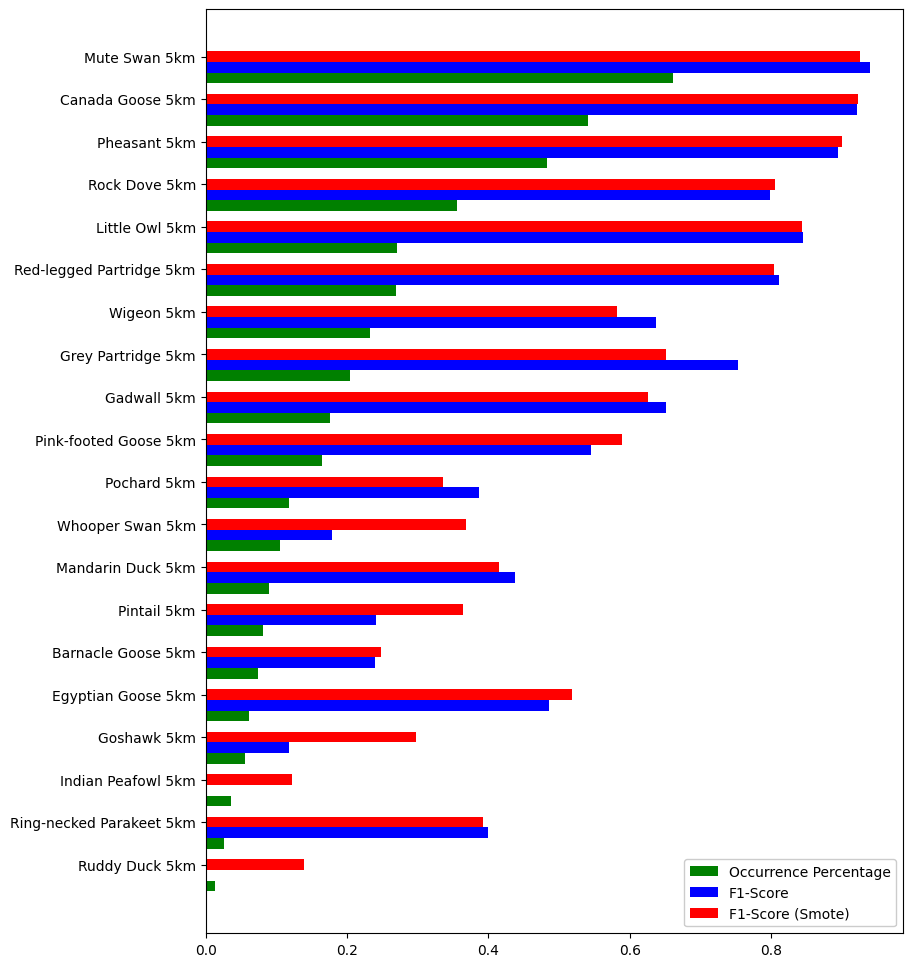

,Labels,Precision,Precision (Smote),Recall,Recall (Smote),F1,F1 (Smote),Occurrence Count,Percentage
9,Mute Swan 5km,0.915267,0.938986,0.965331,0.912943,0.939633,0.925781,5267,0.661268
1,Canada Goose 5km,0.896309,0.911978,0.948837,0.934884,0.921826,0.923289,4305,0.540490
10,Pheasant 5km,0.863107,0.863158,0.927975,0.941545,0.894366,0.900649,3848,0.483114
16,Rock Dove 5km,0.751948,0.755784,0.850220,0.863436,0.798070,0.806032,2830,0.355304
7,Little Owl 5km,0.774510,0.785110,0.931238,0.911591,0.845674,0.843636,2158,0.270935
14,Red-legged Partridge 5km,0.773050,0.757785,0.853229,0.857143,0.811163,0.804408,2150,0.269931
19,Wigeon 5km,0.625793,0.580435,0.647702,0.584245,0.636559,0.582334,1857,0.233145
5,Grey Partridge 5km,0.680982,0.670241,0.843038,0.632911,0.753394,0.651042,1629,0.204520
3,Gadwall 5km,0.743682,0.670968,0.580282,0.585915,0.651899,0.625564,1399,0.175643
11,Pink-footed Goose 5km,0.702970,0.552198,0.445141,0.630094,0.545106,0.588580,1313,0.164846


In [13]:
# Create graphs to show off data
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 12]

occurrence_count, occurrence_percentage = All_bird_occurrences['Occurrence Count'], All_bird_occurrences['Percentage']
precision = []
precision_smote = []
recall = []
recall_smote = []
f1 = []
f1_smote = []
labels = []
for dict in df_dicts:
    precision.append(dict['report']['1']['precision'])
    precision_smote.append(dict['report_smote']['1']['precision'])
    recall.append(dict['report']['1']['recall'])
    recall_smote.append(dict['report_smote']['1']['recall'])
    f1.append(dict['report']['1']['f1-score'])
    f1_smote.append(dict['report_smote']['1']['f1-score'])
    labels.append(dict['name'])



scores = pd.DataFrame({'Labels' : labels, 
                        'Precision': precision, 'Precision (Smote)': precision_smote, 
                        'Recall': recall, 'Recall (Smote)': recall_smote, 
                        'F1': f1, 'F1 (Smote)': f1_smote,
                        'Occurrence Count' : occurrence_count, 'Percentage' : occurrence_percentage} )
                        
scores.sort_values('Occurrence Count', inplace=True)

n=20
r = np.arange(n)
height = 0.25

plt.barh(r, 'Percentage', data=scores, label='Occurrence Percentage', height = height, color='g')
plt.barh(r+height, 'F1', data=scores, label='F1-Score',  height= height, color='b')
plt.barh(r+height*2, 'F1 (Smote)', data=scores, label='F1-Score (Smote)',  height = height, color='r')
plt.legend(framealpha=1, frameon=True)
plt.yticks(r+height*2, scores['Labels'])


plt.show()


scores.sort_values('Occurrence Count', ascending=False)

In [13]:
# Store dictionaries for later use
df_dicts_5km = df_dicts
%store df_dicts_5km

Stored 'df_dicts_5km' (list)


In [14]:
# Export predictions to CSV for QGIS
RESULTS_PATH = 'Datasets/Machine Learning/Results/5km/'
for dict in df_dicts:
    # Join with y_test datafram
    result_df = dict['y_test'] 
    result_df['Predictions'] = dict['predictions_smote']
    display(result_df)
    result_df.to_csv(RESULTS_PATH + dict['name'] + '.csv')
    

Occurrence  Predictions
y         x                                
842500.0  367500.0           0            0
22500.0   197500.0           0            1
          27500.0            0            0
247500.0  252500.0           0            0
737500.0  62500.0            0            0
...                        ...          ...
862500.0  567500.0           0            0
152500.0  232500.0           0            0
1252500.0 592500.0           0            0
1002500.0 322500.0           0            0
192500.0  167500.0           0            0

[1992 rows x 2 columns]

,,Occurrence,Predictions
y,x,,
572500.0,282500.0,1,1
32500.0,162500.0,1,1
37500.0,667500.0,0,0
182500.0,367500.0,1,1
477500.0,332500.0,1,1
...,...,...,...
592500.0,122500.0,0,0
132500.0,482500.0,1,1
1207500.0,432500.0,0,0


Occurrence  Predictions
y         x                                
827500.0  27500.0            0            0
22500.0   392500.0           0            0
          262500.0           0            0
212500.0  317500.0           0            0
727500.0  312500.0           0            0
...                        ...          ...
847500.0  82500.0            0            0
142500.0  512500.0           1            1
1252500.0 512500.0           0            0
1002500.0 337500.0           0            0
167500.0  17500.0            0            0

[1992 rows x 2 columns]

,,Occurrence,Predictions
y,x,,
787500.0,87500.0,0,0
22500.0,2500.0,0,0
27500.0,562500.0,0,0
217500.0,457500.0,1,1
682500.0,387500.0,0,0
...,...,...,...
812500.0,382500.0,0,0
142500.0,342500.0,1,1
1242500.0,372500.0,0,0


Occurrence  Predictions
y         x                                
822500.0  422500.0           0            0
22500.0   647500.0           0            0
          547500.0           0            0
232500.0  392500.0           0            0
727500.0  507500.0           0            0
...                        ...          ...
837500.0  62500.0            0            0
142500.0  447500.0           0            0
1247500.0 517500.0           0            0
987500.0  287500.0           0            0
182500.0  672500.0           0            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
767500.0  547500.0           0            0
27500.0   627500.0           0            0
          507500.0           0            0
222500.0  412500.0           0            0
662500.0  517500.0           0            0
...                        ...          ...
787500.0  567500.0           0            0
147500.0  522500.0           1            0
1242500.0 92500.0            0            0
957500.0  387500.0           0            0
177500.0  557500.0           1            0

[1992 rows x 2 columns]

,,Occurrence,Predictions
y,x,,
827500.0,87500.0,0,0
22500.0,47500.0,0,0
27500.0,567500.0,0,0
227500.0,152500.0,0,0
732500.0,562500.0,0,0
...,...,...,...
852500.0,692500.0,0,0
142500.0,577500.0,0,1
1252500.0,597500.0,0,0


Occurrence  Predictions
y         x                                
722500.0  412500.0           0            0
27500.0   267500.0           0            0
          62500.0            0            0
197500.0  97500.0            0            0
602500.0  512500.0           0            0
...                        ...          ...
747500.0  412500.0           0            0
137500.0  152500.0           0            0
1242500.0 692500.0           0            0
932500.0  162500.0           0            0
162500.0  537500.0           1            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
822500.0  92500.0            0            0
22500.0   217500.0           0            0
          137500.0           0            0
212500.0  292500.0           0            1
717500.0  197500.0           0            0
...                        ...          ...
842500.0  372500.0           0            0
137500.0  392500.0           1            0
1247500.0 87500.0            0            0
997500.0  362500.0           0            0
172500.0  532500.0           0            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
582500.0  287500.0           1            1
42500.0   192500.0           0            1
          72500.0            0            0
192500.0  557500.0           1            1
487500.0  317500.0           1            1
...                        ...          ...
607500.0  422500.0           1            1
137500.0  302500.0           1            1
1192500.0 637500.0           0            0
737500.0  417500.0           0            0
162500.0  482500.0           1            1

[1992 rows x 2 columns]

,,Occurrence,Predictions
y,x,,
642500.0,327500.0,1,1
32500.0,142500.0,0,1
37500.0,577500.0,0,0
192500.0,352500.0,1,1
537500.0,87500.0,1,0
...,...,...,...
662500.0,347500.0,0,1
137500.0,512500.0,1,1
1217500.0,402500.0,0,0


,,Occurrence,Predictions
y,x,,
817500.0,352500.0,1,1
22500.0,37500.0,0,0
27500.0,642500.0,0,0
272500.0,297500.0,0,0
722500.0,327500.0,1,1
...,...,...,...
837500.0,372500.0,1,1
162500.0,67500.0,0,0
1242500.0,212500.0,0,0


Occurrence  Predictions
y         x                                
837500.0  152500.0           0            1
22500.0   367500.0           0            0
          222500.0           0            0
237500.0  217500.0           0            1
722500.0  332500.0           1            0
...                        ...          ...
857500.0  267500.0           1            0
147500.0  287500.0           1            1
1252500.0 152500.0           0            0
1012500.0 92500.0            0            0
187500.0  572500.0           0            1

[1992 rows x 2 columns]

,,Occurrence,Predictions
y,x,,
807500.0,247500.0,0,0
17500.0,27500.0,0,0
22500.0,507500.0,0,0
222500.0,32500.0,0,0
707500.0,677500.0,0,0
...,...,...,...
827500.0,362500.0,0,0
142500.0,302500.0,0,1
1242500.0,242500.0,0,0


Occurrence  Predictions
y         x                                
747500.0  162500.0           0            0
32500.0   612500.0           0            0
          482500.0           0            0
207500.0  202500.0           0            0
627500.0  272500.0           0            0
...                        ...          ...
772500.0  292500.0           0            0
142500.0  532500.0           1            1
1242500.0 452500.0           0            0
937500.0  542500.0           0            0
167500.0  307500.0           0            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
857500.0  647500.0           0            0
22500.0   632500.0           0            0
          562500.0           0            0
227500.0  442500.0           0            0
752500.0  517500.0           0            0
...                        ...          ...
872500.0  267500.0           0            0
147500.0  322500.0           0            0
1252500.0 547500.0           0            0
1017500.0 362500.0           0            0
177500.0  37500.0            0            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
712500.0  332500.0           1            0
27500.0   437500.0           0            0
          137500.0           0            1
197500.0  447500.0           1            1
607500.0  247500.0           0            0
...                        ...          ...
732500.0  332500.0           0            1
142500.0  692500.0           0            0
1232500.0 552500.0           0            0
902500.0  302500.0           0            0
167500.0  562500.0           1            1

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
857500.0  512500.0           0            0
22500.0   587500.0           0            0
          447500.0           0            0
237500.0  512500.0           0            0
752500.0  77500.0            0            0
...                        ...          ...
872500.0  512500.0           0            0
142500.0  167500.0           0            0
1252500.0 422500.0           0            0
1007500.0 72500.0            0            0
182500.0  142500.0           0            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
847500.0  507500.0           0            0
27500.0   597500.0           0            0
          472500.0           0            0
267500.0  387500.0           0            0
742500.0  197500.0           0            0
...                        ...          ...
862500.0  607500.0           0            0
162500.0  447500.0           0            0
1247500.0 87500.0            0            0
1002500.0 462500.0           0            0
202500.0  237500.0           0            0

[1992 rows x 2 columns]

Occurrence  Predictions
y         x                                
787500.0  97500.0            0            0
27500.0   167500.0           0            0
          107500.0           0            0
232500.0  602500.0           1            0
687500.0  72500.0            0            0
...                        ...          ...
807500.0  192500.0           1            1
147500.0  602500.0           0            1
1237500.0 332500.0           0            0
957500.0  122500.0           0            0
182500.0  582500.0           1            0

[1992 rows x 2 columns]

In [15]:
for dict in df_dicts:
    print(dict['name'])
    display(dict['kbest']['Dataframe'])

Barnacle Goose 5km


,F Score,P Value,Attribute
25,1227.949077,2.545634e-250,Inflowing drainage direction
23,1020.748820,7.391612e-211,Surface type
21,983.053244,1.401801e-203,Elevation
26,511.443416,8.364957e-110,Fertiliser K
27,511.443416,8.364957e-110,Fertiliser N
28,511.443416,8.364957e-110,Fertiliser P
3,462.292259,1.002663e-99,Improve grassland
22,360.982411,9.334063e-79,Cumulative catchment area
24,322.588411,9.713871e-71,Outflowing drainage direction
2,322.261898,1.136958e-70,Arable


Canada Goose 5km


,F Score,P Value,Attribute
23,13690.149107,0.000000e+00,Surface type
21,13106.121105,0.000000e+00,Elevation
25,10572.095214,0.000000e+00,Inflowing drainage direction
26,7654.297733,0.000000e+00,Fertiliser K
27,7654.297733,0.000000e+00,Fertiliser N
28,7654.297733,0.000000e+00,Fertiliser P
29,4195.605263,0.000000e+00,Chlorothalonil_5km
30,4195.605263,0.000000e+00,Glyphosate_5km
31,4195.605263,0.000000e+00,Mancozeb_5km
32,4195.605263,0.000000e+00,Mecoprop-P_5km


Egyptian Goose 5km


,F Score,P Value,Attribute
26,2983.128760,0.000000e+00,Fertiliser K
27,2983.128760,0.000000e+00,Fertiliser N
28,2983.128760,0.000000e+00,Fertiliser P
23,1377.421605,3.086937e-278,Surface type
25,992.142694,2.448748e-205,Inflowing drainage direction
21,919.257319,3.425183e-191,Elevation
2,913.921650,3.757007e-190,Arable
29,777.091220,2.934139e-163,Chlorothalonil_5km
30,777.091220,2.934139e-163,Glyphosate_5km
31,777.091220,2.934139e-163,Mancozeb_5km


Gadwall 5km


,F Score,P Value,Attribute
26,4515.330213,0.000000e+00,Fertiliser K
27,4515.330213,0.000000e+00,Fertiliser N
28,4515.330213,0.000000e+00,Fertiliser P
23,3184.992011,0.000000e+00,Surface type
25,2723.133762,0.000000e+00,Inflowing drainage direction
21,2406.022115,0.000000e+00,Elevation
2,1966.244495,0.000000e+00,Arable
3,1231.056795,6.618329e-251,Improve grassland
29,1214.046569,1.060403e-247,Chlorothalonil_5km
30,1214.046569,1.060403e-247,Glyphosate_5km


Goshawk 5km


,F Score,P Value,Attribute
21,1152.957368,3.838405e-236,Elevation
23,1141.475518,5.825497e-234,Surface type
25,949.198977,5.121685e-197,Inflowing drainage direction
29,787.722786,2.305292e-165,Chlorothalonil_5km
30,787.722786,2.305292e-165,Glyphosate_5km
31,787.722786,2.305292e-165,Mancozeb_5km
32,787.722786,2.305292e-165,Mecoprop-P_5km
34,787.722786,2.305292e-165,Pendimethalin_5km
0,657.400077,2.208469e-139,Deciduous woodland
3,627.392411,2.416062e-133,Improve grassland


Grey Partridge 5km


,F Score,P Value,Attribute
26,6271.935655,0.000000e+00,Fertiliser K
27,6271.935655,0.000000e+00,Fertiliser N
28,6271.935655,0.000000e+00,Fertiliser P
23,4597.238354,0.000000e+00,Surface type
2,4174.660137,0.000000e+00,Arable
21,3785.784065,0.000000e+00,Elevation
25,3602.849751,0.000000e+00,Inflowing drainage direction
29,1561.563980,5.115844e-312,Chlorothalonil_5km
30,1561.563980,5.115844e-312,Glyphosate_5km
31,1561.563980,5.115844e-312,Mancozeb_5km


Indian Peafowl 5km


,F Score,P Value,Attribute
26,1401.150933,1.256201e-282,Fertiliser K
27,1401.150933,1.256201e-282,Fertiliser N
28,1401.150933,1.256201e-282,Fertiliser P
23,792.263164,2.915059e-166,Surface type
2,701.104487,3.862323e-148,Arable
21,578.148305,2.189384e-123,Elevation
3,545.827122,8.086054e-117,Improve grassland
25,524.382331,1.902480e-112,Inflowing drainage direction
38,487.290667,7.370916e-105,Tri-allate_5km
29,444.347581,4.966029e-96,Chlorothalonil_5km


Little Owl 5km


,F Score,P Value,Attribute
26,14865.981572,0.000000e+00,Fertiliser K
27,14865.981572,0.000000e+00,Fertiliser N
28,14865.981572,0.000000e+00,Fertiliser P
23,6857.748193,0.000000e+00,Surface type
25,5386.245994,0.000000e+00,Inflowing drainage direction
21,5359.355245,0.000000e+00,Elevation
2,4395.443997,0.000000e+00,Arable
29,3029.229250,0.000000e+00,Chlorothalonil_5km
30,3029.229250,0.000000e+00,Glyphosate_5km
31,3029.229250,0.000000e+00,Mancozeb_5km


Mandarin Duck 5km


,F Score,P Value,Attribute
26,3499.336953,0.000000e+00,Fertiliser K
27,3499.336953,0.000000e+00,Fertiliser N
28,3499.336953,0.000000e+00,Fertiliser P
23,2033.821770,0.000000e+00,Surface type
29,1803.002674,0.000000e+00,Chlorothalonil_5km
30,1803.002674,0.000000e+00,Glyphosate_5km
31,1803.002674,0.000000e+00,Mancozeb_5km
32,1803.002674,0.000000e+00,Mecoprop-P_5km
34,1803.002674,0.000000e+00,Pendimethalin_5km
36,1714.730650,0.000000e+00,Prosulfocarb_5km


Mute Swan 5km


,F Score,P Value,Attribute
21,13258.103579,0.000000e+00,Elevation
23,11515.117494,0.000000e+00,Surface type
25,10658.285644,0.000000e+00,Inflowing drainage direction
26,4008.850443,0.000000e+00,Fertiliser K
27,4008.850443,0.000000e+00,Fertiliser N
28,4008.850443,0.000000e+00,Fertiliser P
29,2394.708388,0.000000e+00,Chlorothalonil_5km
30,2394.708388,0.000000e+00,Glyphosate_5km
31,2394.708388,0.000000e+00,Mancozeb_5km
32,2394.708388,0.000000e+00,Mecoprop-P_5km


Pheasant 5km


,F Score,P Value,Attribute
23,10050.271292,0.000000e+00,Surface type
21,8841.943280,0.000000e+00,Elevation
25,7309.294901,0.000000e+00,Inflowing drainage direction
26,5420.435199,0.000000e+00,Fertiliser K
27,5420.435199,0.000000e+00,Fertiliser N
28,5420.435199,0.000000e+00,Fertiliser P
29,3270.520292,0.000000e+00,Chlorothalonil_5km
30,3270.520292,0.000000e+00,Glyphosate_5km
31,3270.520292,0.000000e+00,Mancozeb_5km
32,3270.520292,0.000000e+00,Mecoprop-P_5km


Pink-footed Goose 5km


,F Score,P Value,Attribute
25,3058.357364,0.000000e+00,Inflowing drainage direction
23,2873.839868,0.000000e+00,Surface type
21,2752.743624,0.000000e+00,Elevation
2,1607.983542,1.980709e-320,Arable
24,900.562185,1.520435e-187,Outflowing drainage direction
3,796.768219,3.749922e-167,Improve grassland
26,532.616285,3.976135e-114,Fertiliser K
27,532.616285,3.976135e-114,Fertiliser N
28,532.616285,3.976135e-114,Fertiliser P
0,495.339143,1.652140e-106,Deciduous woodland


Pintail 5km


,F Score,P Value,Attribute
25,1193.390686,8.415495e-244,Inflowing drainage direction
26,1059.117690,3.107133e-218,Fertiliser K
27,1059.117690,3.107133e-218,Fertiliser N
28,1059.117690,3.107133e-218,Fertiliser P
23,1044.622083,1.885397e-215,Surface type
21,953.980643,6.038807e-198,Elevation
2,678.915030,1.065146e-143,Arable
3,511.570131,7.880582e-110,Improve grassland
29,437.458138,1.308414e-94,Chlorothalonil_5km
30,437.458138,1.308414e-94,Glyphosate_5km


Pochard 5km


,F Score,P Value,Attribute
26,2671.442257,0.000000e+00,Fertiliser K
27,2671.442257,0.000000e+00,Fertiliser N
28,2671.442257,0.000000e+00,Fertiliser P
23,1871.268813,0.000000e+00,Surface type
25,1596.293317,2.578949e-318,Inflowing drainage direction
21,1458.059785,4.121005e-293,Elevation
2,1323.591102,3.098156e-268,Arable
29,806.540025,4.403351e-169,Chlorothalonil_5km
30,806.540025,4.403351e-169,Glyphosate_5km
31,806.540025,4.403351e-169,Mancozeb_5km


Red-legged Partridge 5km


,F Score,P Value,Attribute
26,10028.081544,0.000000e+00,Fertiliser K
27,10028.081544,0.000000e+00,Fertiliser N
28,10028.081544,0.000000e+00,Fertiliser P
23,6569.078657,0.000000e+00,Surface type
21,5268.430630,0.000000e+00,Elevation
25,4818.581261,0.000000e+00,Inflowing drainage direction
2,4323.612248,0.000000e+00,Arable
29,2736.285944,0.000000e+00,Chlorothalonil_5km
30,2736.285944,0.000000e+00,Glyphosate_5km
31,2736.285944,0.000000e+00,Mancozeb_5km


Ring-necked Parakeet 5km


,F Score,P Value,Attribute
20,1621.475487,7.410985e-323,Suburban
19,1336.970983,9.993620e-271,Urban
26,1074.183474,4.023650e-221,Fertiliser K
27,1074.183474,4.023650e-221,Fertiliser N
28,1074.183474,4.023650e-221,Fertiliser P
23,565.996873,6.403263e-121,Surface type
25,427.527239,1.468349e-92,Inflowing drainage direction
21,400.020717,7.218079e-87,Elevation
29,391.123758,5.053244e-85,Chlorothalonil_5km
30,391.123758,5.053244e-85,Glyphosate_5km


Rock Dove 5km


,F Score,P Value,Attribute
23,6619.008028,0.000000e+00,Surface type
21,5838.703214,0.000000e+00,Elevation
25,5360.017492,0.000000e+00,Inflowing drainage direction
26,4904.971327,0.000000e+00,Fertiliser K
27,4904.971327,0.000000e+00,Fertiliser N
28,4904.971327,0.000000e+00,Fertiliser P
29,2334.727881,0.000000e+00,Chlorothalonil_5km
30,2334.727881,0.000000e+00,Glyphosate_5km
31,2334.727881,0.000000e+00,Mancozeb_5km
32,2334.727881,0.000000e+00,Mecoprop-P_5km


Ruddy Duck 5km


,F Score,P Value,Attribute
26,506.011518,1.079756e-108,Fertiliser K
27,506.011518,1.079756e-108,Fertiliser N
28,506.011518,1.079756e-108,Fertiliser P
20,283.173640,1.818362e-62,Suburban
19,266.772577,5.184196e-59,Urban
23,265.160749,1.134062e-58,Surface type
13,254.219428,2.313511e-56,Freshwater
25,195.841301,5.587129e-44,Inflowing drainage direction
21,180.145187,1.243031e-40,Elevation
3,160.625779,1.855127e-36,Improve grassland


Whooper Swan 5km


,F Score,P Value,Attribute
25,1446.473544,5.550292e-291,Inflowing drainage direction
21,1251.247669,1.058098e-254,Elevation
23,1191.375081,2.023384e-243,Surface type
3,445.722249,2.586255e-96,Improve grassland
2,374.066418,1.765675e-81,Arable
24,320.036326,3.324479e-70,Outflowing drainage direction
0,238.820965,4.174954e-53,Deciduous woodland
26,223.204418,8.516960e-50,Fertiliser K
27,223.204418,8.516960e-50,Fertiliser N
28,223.204418,8.516960e-50,Fertiliser P


Wigeon 5km


,F Score,P Value,Attribute
25,3527.304911,0.000000e+00,Inflowing drainage direction
23,3350.481828,0.000000e+00,Surface type
21,3275.722008,0.000000e+00,Elevation
26,1560.675179,7.419696e-312,Fertiliser K
27,1560.675179,7.419696e-312,Fertiliser N
28,1560.675179,7.419696e-312,Fertiliser P
3,1300.349746,6.719167e-264,Improve grassland
2,1127.764279,2.364062e-231,Arable
24,888.494256,3.471083e-185,Outflowing drainage direction
29,847.052726,4.617711e-177,Chlorothalonil_5km
